In [1]:
# Imports
import mdtraj as md
import nglview
import neutromeratio
import numpy as np
import matplotlib.pyplot as plt
from simtk import unit
import seaborn as sns
import torch
plt.style.use('seaborn')

# load top and traj
name = 'SAMPLmol2'
base = f'../calculated/'

traj = f'{base}/{name}_lambda_0.0000_in_droplet.dcd'
top  = f'{base}/{name}_in_droplet.pdb'

ani_traj = md.load_dcd(traj, top)

[__init__.py:17 - <module>()] Enabling RDKit 2021.03.3 jupyter extensions
[utils.py:157 - _init_num_threads()] NumExpr defaulting to 8 threads.


In [2]:
# extract residues
ani_traj_short = ani_traj[::50]
all_residues = list(ani_traj_short.top.residues)
water_residues = all_residues[1:]
angle_indices = []

for i, residue in enumerate(water_residues):
    O,H1,H2 = [a.index for a in residue.atoms]
    angle_indices.append((H1,O,H2))
angle_indices = np.array(angle_indices)
angles = md.compute_angles(ani_traj_short, angle_indices=angle_indices)
angles.shape


(401, 76)

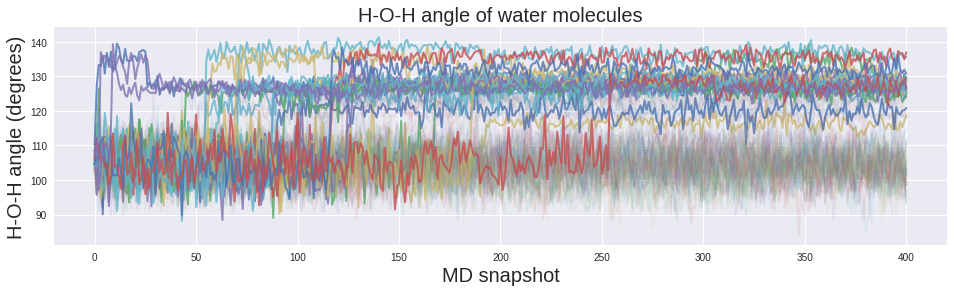

In [3]:
# plot angels
plt.figure(figsize=(16,4))
for ang in angles.T:
    if any(a * 180 / np.pi > 130 for a in ang):
        plt.plot(ang * 180 / np.pi, alpha=.8, linewidth=2);
    else:
        plt.plot(ang * 180 / np.pi, alpha=.1, linewidth=2);
fontsize = 20
plt.title('H-O-H angle of water molecules', fontsize = fontsize)
plt.xlabel('MD snapshot', fontsize = fontsize)
plt.ylabel('H-O-H angle (degrees)', fontsize = fontsize)

plt.show()

In [4]:
# generating energy function for tautomer system
from neutromeratio.analysis import setup_alchemical_system_and_energy_function
from neutromeratio.ani import AlchemicalANI1ccx
from neutromeratio.constants import hartree_to_kJ_mol
energy_function, tautomer, flipped = setup_alchemical_system_and_energy_function(name=name, env='droplet', ANImodel=AlchemicalANI1ccx, base_path=f'../calculated/{name}', diameter=16)

[analysis.py:542 - setup_alchemical_system_and_energy_function()] AlchemicalANI1ccx is called NOT in training mode! This will take forever.


In [5]:
# define functions to calculate the atomic energy contribution for each oxygen and the ensemble stddev
from tqdm import tqdm
def compute_atomic_energy_contributions_without_dummy_atom(traj, model, energy_function, dummy_atom):
    n_models = 8
    
    xyz_in_angstroms = traj.xyz * 10
    coordinates = torch.tensor(xyz_in_angstroms)
    n_snapshots = len(coordinates)
    
    species = energy_function.species

    mod_species = torch.cat((species[:, :dummy_atom],  species[:, dummy_atom+1:]), dim=1)
    species_list = list(map(int, mod_species[0]))
    n_atoms = len(species_list)
    
    print('n_snapshots: {}, n_atoms: {}, n_models: {}'.format(n_snapshots, n_atoms, n_models))
    
    mod_coordinates = torch.cat((coordinates[:, :dummy_atom],  coordinates[:, dummy_atom+1:]), dim=1)
    mod_species = torch.stack([mod_species[0]] * len(mod_coordinates))
    print('mod_species.shape', mod_species.shape)
    print('mod_coordinates.shape', mod_coordinates.shape)
    _, mod_aevs = model.aev_computer((mod_species, mod_coordinates))
    
    
    raw_energies = np.zeros((n_snapshots, n_atoms, n_models))
    for i in tqdm(range(n_atoms)):
        for j in range(n_models):
            if species_list[i] == 0:
                m = model.original_neural_network[j].H
            if species_list[i] == 1:
                m = model.original_neural_network[j].C
            if species_list[i] == 2:
                m = model.original_neural_network[j].N
            if species_list[i] == 3:
                m = model.original_neural_network[j].O

            raw_energies[:,i,j] = m.forward(mod_aevs[:,i,:]).detach().flatten()
    return raw_energies

def compute_endstate_atomic_energy_contributions(traj, model, energy_function):
    assert(len(model.alchemical_atoms) == 2)
    
    if len(traj) > 300: print('warning! may want to break traj into bite-size chunks')
    
    dummy_0, dummy_1 = model.alchemical_atoms
    print('(dummy_0, dummy_1)', dummy_0, dummy_1)
    
    raw_energies_without_dummy_0 = compute_atomic_energy_contributions_without_dummy_atom(
        traj, model, energy_function, dummy_0)
    
    raw_energies_without_dummy_1 = compute_atomic_energy_contributions_without_dummy_atom(
        traj, model, energy_function, dummy_1)
    
    return raw_energies_without_dummy_0, raw_energies_without_dummy_1


In [6]:
# calculate atomic energy contribution with the endstate potentials (excluding the dummy atoms)
model = energy_function.model
raw_energies_without_dummy_0, raw_energies_without_dummy_1 = compute_endstate_atomic_energy_contributions(ani_traj_short, model, energy_function)
raw_energies = raw_energies_without_dummy_0

warning! may want to break traj into bite-size chunks
(dummy_0, dummy_1) 18 11
n_snapshots: 401, n_atoms: 246, n_models: 8
mod_species.shape torch.Size([401, 246])
mod_coordinates.shape torch.Size([401, 246, 3])


100%|██████████| 246/246 [00:02<00:00, 83.13it/s]


n_snapshots: 401, n_atoms: 246, n_models: 8
mod_species.shape torch.Size([401, 246])
mod_coordinates.shape torch.Size([401, 246, 3])


100%|██████████| 246/246 [00:03<00:00, 78.97it/s]


Text(0.5, 1.0, 'ensemble stddev by atom')

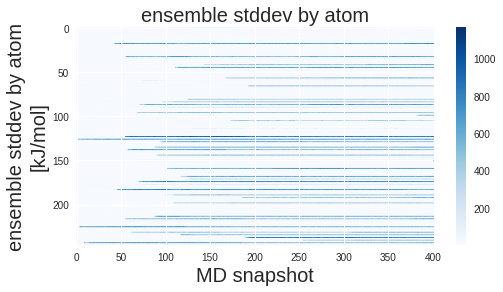

In [7]:
# plot ensemble stddev
plt.figure(figsize=(8,4))
ensemble_discrepancy_kj_mol = (raw_energies.std(-1).T) * hartree_to_kJ_mol
plt.imshow(ensemble_discrepancy_kj_mol,  cmap='Blues', aspect='auto')
plt.colorbar()
plt.xlabel('MD snapshot', fontsize=fontsize)
plt.ylabel('ensemble stddev by atom\n[kJ/mol]',fontsize=fontsize)
plt.title('ensemble stddev by atom',fontsize=fontsize)
#plt.savefig('ensemble_stddev_by_atom_lam={}.png'.format(lam_str), dpi=300, bbox_inches='tight')


[legend.py:1225 - _parse_legend_args()] No handles with labels found to put in legend.


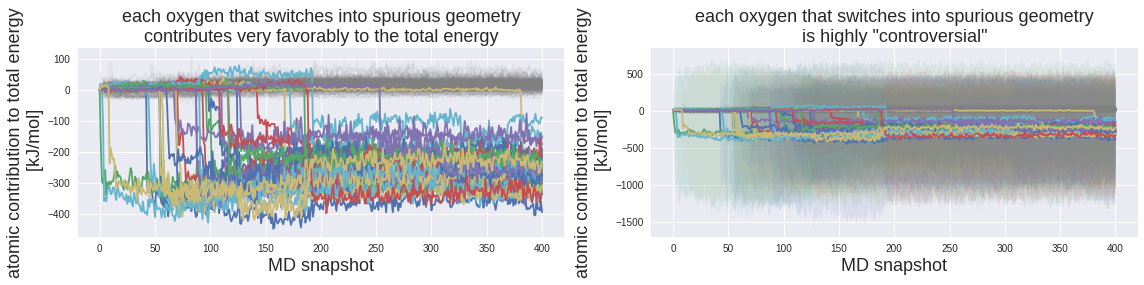

In [8]:
# extract ids with stddev abouve 400 kJ/mol 
bad_inds = np.where(ensemble_discrepancy_kj_mol.max(1) > 400)[0]
# plot per energy contributions and stddev
fontsize -= 2
def format_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax
def plot_energy_contributions(raw_energies, bad_inds, plot_uncertainty_band=True):
    """raw_energies is an array of shape (n_snapshots, n_atoms, n_models), assumed in hartree
    bad_inds is a list of atom indices that we want to color -- all other atoms will be grey
    """
    plt.plot(
        (raw_energies.mean(-1) - raw_energies.mean(-1)[0]) * hartree_to_kJ_mol,
    c='grey', alpha=0.1)


    mean = (raw_energies.mean(-1)[:,bad_inds] - raw_energies.mean(-1)[0,bad_inds]) * hartree_to_kJ_mol
    stddev = (hartree_to_kJ_mol * raw_energies).std(-1)[:,bad_inds]
    for i in range(len(bad_inds)):
        plt.plot(np.arange(len(raw_energies)), mean[:,i])
        if plot_uncertainty_band:
            plt.fill_between(np.arange(len(raw_energies)),
                         mean[:,i] - stddev[:,i], mean[:,i] + stddev[:,i], alpha=0.1)


    plt.ylabel('atomic contribution to total energy\n [kJ/mol]',fontsize=fontsize)
    plt.xlabel('MD snapshot',fontsize=fontsize)
    start_of_sentence = 'each oxygen that switches into spurious geometry'
    end_of_sentence = 'contributes very favorably to the total energy'
    if plot_uncertainty_band:
        end_of_sentence = 'is highly "controversial"'
    plt.title('{}\n{}'.format(start_of_sentence, end_of_sentence), fontsize=fontsize)

    plt.tight_layout()
#    plt.ylabel('atomic contribution to total energy (kJ/mol)\n(centered at contribution at $t=0$)')

def plot_total_uncertainty(raw_energies):
    plt.plot((raw_energies * hartree_to_kJ_mol).sum(1).std(-1))
    plt.xlabel('MD snapshot',fontsize=fontsize)
    plt.ylabel('ensemble stddev in total energy\n [kJ/mol]',fontsize=fontsize)
    plt.title('ensemble discrepancy for total energy increases',fontsize=fontsize)
    plt.tight_layout()
    
plt.figure(figsize=(16,4))
ax = format_ax(plt.subplot(1,2,1))
plot_energy_contributions(raw_energies, bad_inds, plot_uncertainty_band=False)

ax = format_ax(plt.subplot(1,2,2))
plot_energy_contributions(raw_energies, bad_inds, plot_uncertainty_band=True)

plt.legend()

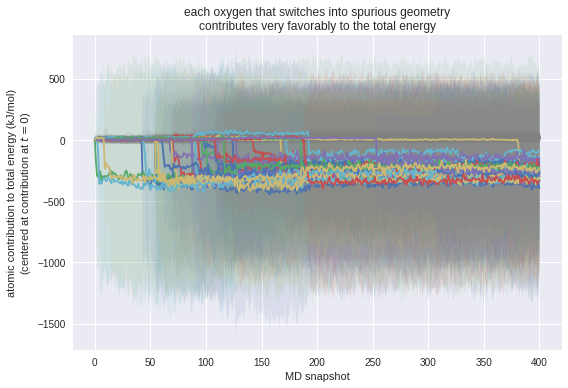

In [9]:
raw_energies = raw_energies_without_dummy_0

plt.plot(
    (raw_energies.mean(-1) - raw_energies.mean(-1)[0]) * hartree_to_kJ_mol,
c='grey', alpha=0.1)


mean = (raw_energies.mean(-1)[:,bad_inds] - raw_energies.mean(-1)[0,bad_inds]) * hartree_to_kJ_mol
stddev = (hartree_to_kJ_mol * raw_energies).std(-1)[:,bad_inds]
for i in range(len(bad_inds)):
    plt.plot(np.arange(len(raw_energies)), mean[:,i])
    plt.fill_between(np.arange(len(raw_energies)),
                 mean[:,i] - stddev[:,i], mean[:,i] + stddev[:,i], alpha=0.1)


plt.ylabel('atomic contribution to total energy (kJ/mol)\n(centered at contribution at $t=0$)')
plt.xlabel('MD snapshot')

plt.title('each oxygen that switches into spurious geometry\ncontributes very favorably to the total energy')

plt.tight_layout()
#plt.savefig('per_atom_energy_contributions_{}_w_uncertainty.png'.format(lam_str), dpi=300, bbox_inches='tight')
